In [103]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
import seaborn as sns
sns.set()


class memory_cell():
    """
    Memory cell to store the impression of another agent is simply its defection rate
    
    Attributes
    ------------
    defect_number_ : Number of defection
    play_number_   : Number of Plays
    
    """
    def __init__(self, act):
        self.defect_number_ = 0
        self.play_number_ = 1
        
        if act == 'D' : self.defect_number_ += 1
    
    def update(self, act):
        if act == 'D' : self.defect_number_ += 1
        self.play_number_ += 1
    
    def impression(self):
        return self.defect_number_/max(1, self.play_number_)
    
class agent():
    """
    Player of a Prisoners Dilemma Game. 
    
    Parameters
    ------------
    ID     : Unique identifier for the agent
    pc     : Probability of cooperation
    M      : Memory Size/Capacity 
    
        
    Attributes
    ------------
    score_  : Accumulates payoffs (define success/fitness)
    memory_ : Store information about a limited number (M) of opponent players.
             Dictionary (key, value) = (other_agent, memory_cell)
    
    """
    def __init__(self, ID, pc = 1, M = 1):
        self.ID, self.pc, self.M = ID, pc, M
        self.score_ = 0
        self.memory_ = dict()
        
    def act(self):
        """
        Two possible actions
            - cooperate with probability pc
            - defect with probability 1 - pc
        """
        if np.random.rand() < self.pc:
            return 'C'
        return 'D'
    
    def know(self, other):
        return other in self.memory_
    
    def perceive_as_defector(self, other):
        if self.know(other):
            return self.memory_[other].impression() > 0.5
        return False
    
    def take_payoff(self, payoff):
        self.score_ += payoff
    
    def learn(self, other, act):  
        if self.know(other):      
            self.memory_[other].update(act)  
        else:
            self.forget()
            self.memory_[other] = memory_cell(act)
        
    def forget(self):
        if len(self.memory_) == self.M:
            cooperators = [k for (k,v) in self.memory_.items() if v.impression() < 0.5]
            if len(cooperators) > 0:
                del self.memory_[random.choice(cooperators)]
            else:
                del self.memory_[random.choice(list(self.memory_.keys()))]
                
    def display(self):
        return [(k.ID, v.impression()) for (k,v) in self.memory_.items()]
    

In [104]:
payoff = {'CC':3,'CD':0,'DC':5,'DD':1}

A = agent(ID = 0, pc = 0.5)
B = agent(ID = 0, pc = 1)

In [105]:
A_action, B_action = A.act(), B.act()
print(A_action, B_action)

A.learn(B, B_action)
B.learn(A, A_action)

C C


In [106]:
A.memory_[B].impression(), A.score_

(0.0, 0)

In [107]:
B.memory_[A].impression(), B.score_

(0.0, 0)

In [108]:
B.memory_.items()

dict_items([(<__main__.agent object at 0x1a1c073208>, <__main__.memory_cell object at 0x1a1c68f978>)])

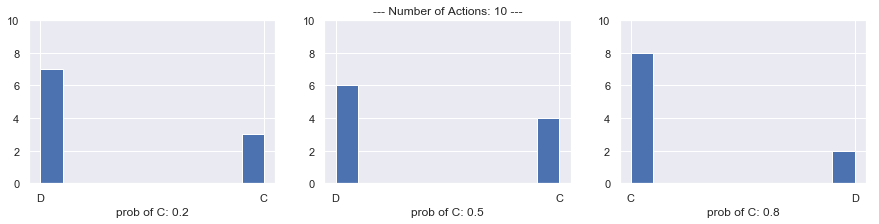

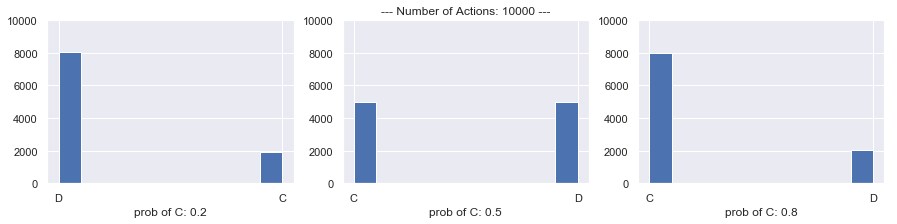

In [109]:
for number_of_actions in [10, 10000]:    
    plt.figure(figsize = (15,3))
    plt.subplot(1,3,1)
    prob = 0.2
    a = agent(ID = 0, pc = prob)
    a_actions = [a.act() for i in range(number_of_actions)]
    plt.hist(a_actions)
    plt.ylim((0,number_of_actions))
    plt.xlabel('prob of C: {}'.format(prob))

    plt.subplot(1,3,2)
    prob = 0.5
    a = agent(ID = 0, pc = prob)
    a_actions = [a.act() for i in range(number_of_actions)]
    plt.hist(a_actions)
    plt.ylim((0,number_of_actions))
    plt.xlabel('prob of C: {}'.format(prob))
    plt.title("--- Number of Actions: {} ---".format(number_of_actions))

    plt.subplot(1,3,3)
    prob = 0.8
    a = agent(ID = 0, pc = prob)
    a_actions = [a.act() for i in range(number_of_actions)]
    plt.hist(a_actions)
    plt.ylim((0,number_of_actions))
    plt.xlabel('prob of C: {}'.format(prob))


In [110]:
class abm():
    def __init__(self, N = 100, M = 100, time = 1000, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N, self.time = N, time
        self.population = [agent(i, pc = np.random.rand(), M = M) for i in range(self.N)]
        self.payoff = payoff
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.take_payoff(self.payoff[A_action+B_action])
            B.take_payoff(self.payoff[B_action+A_action])
            
    def display(self):
        df = pd.DataFrame(columns=['ID','pC', 'score', 'Memory'])
        for A in self.population:
            df.loc[A.ID] = pd.Series({'ID':A.ID, 'pC':A.pc, 'score':A.score_, 'Memory':A.display()})
        return df

In [111]:
sim = abm()
sim.world()
result = sim.display()
result.head(7)

,ID,pC,score,Memory
0,0,0.548300,49,"[(45, 0.0), (99, 1.0), (79, 0.0), (62, 0.0), (..."
1,1,0.065500,58,"[(16, 0.0), (96, 1.0), (53, 0.0), (80, 1.0), (..."
2,2,0.737288,34,"[(55, 1.0), (84, 1.0), (62, 0.0), (38, 0.0), (..."
3,3,0.005007,44,"[(72, 0.0), (67, 0.0), (22, 0.0), (18, 1.0), (..."
4,4,0.788597,31,"[(40, 1.0), (47, 0.5), (50, 1.0), (57, 0.0), (..."
5,5,0.522193,26,"[(66, 0.0), (29, 1.0), (85, 0.0), (61, 0.0), (..."
6,6,0.997527,18,"[(78, 1.0), (30, 1.0), (97, 1.0), (54, 1.0), (..."


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bd49da0>]],
      dtype=object)

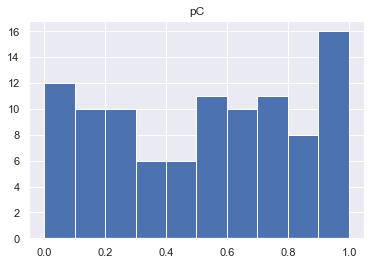

In [112]:
result.hist()

In [113]:
ture_characters = {A.ID: A.pc for A in sim.population}

In [114]:
sim.population[40].display()

[(65, 1.0),
 (4, 0.0),
 (10, 1.0),
 (48, 1.0),
 (54, 1.0),
 (25, 1.0),
 (19, 1.0),
 (14, 1.0),
 (61, 0.0),
 (79, 0.0),
 (60, 1.0),
 (17, 1.0),
 (81, 0.0),
 (70, 1.0),
 (30, 1.0),
 (88, 1.0)]

In [57]:
k = 4
len(sim.population[k].memory_), sim.population[k].M

(23, 100)

In [41]:
sim = abm()

In [53]:
sim.population[5].M

100

In [59]:
d = {k:k for k in range(10)}

In [61]:
del d[5]

In [63]:
del d[3]

In [65]:
del d[4]

In [66]:
d

{0: 0, 1: 1, 2: 2, 6: 6, 7: 7, 8: 8, 9: 9}

In [67]:
len(d)

7

In [69]:
d[6] += 5

In [70]:
d

{0: 0, 1: 1, 2: 2, 6: 11, 7: 7, 8: 8, 9: 9}

In [115]:
m1 = memory_cell(act = 'D')
m2 = memory_cell(act = 'C')

In [116]:
m1.impression(), m2.impression()

(1.0, 0.0)

In [117]:
d = {A: m1, B:m2}

In [118]:
d[A].impression(), d[B].impression()

(1.0, 0.0)

In [119]:
del d[A]

In [120]:
d[B].impression()

0.0

In [121]:
m1

In [122]:
A

In [125]:
del m2

In [127]:
d[B].impression()

0.0